In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
### EDA video_games_sales.csv ###
df_video_games = pd.read_csv('Datos/video_games_sales.csv')
print("Primeras filas del dataset")
print(df_video_games.head(10))



Primeras filas del dataset
   Rank                       Name Platform    Year         Genre Publisher  \
0     1                 Wii Sports      Wii  2006.0        Sports  Nintendo   
1     2          Super Mario Bros.      NES  1985.0      Platform  Nintendo   
2     3             Mario Kart Wii      Wii  2008.0        Racing  Nintendo   
3     4          Wii Sports Resort      Wii  2009.0        Sports  Nintendo   
4     5   Pokemon Red/Pokemon Blue       GB  1996.0  Role-Playing  Nintendo   
5     6                     Tetris       GB  1989.0        Puzzle  Nintendo   
6     7      New Super Mario Bros.       DS  2006.0      Platform  Nintendo   
7     8                   Wii Play      Wii  2006.0          Misc  Nintendo   
8     9  New Super Mario Bros. Wii      Wii  2009.0      Platform  Nintendo   
9    10                  Duck Hunt      NES  1984.0       Shooter  Nintendo   

   NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  
0     41.49     29.02      3.77         8.

In [7]:
print("\nDimensiones del dataset:")
print(f"Filas: {df_video_games.shape[0]}, Columnas: {df_video_games.shape[1]}")


Dimensiones del dataset:
Filas: 16598, Columnas: 11


In [8]:
print("\nTipos de datos:")
print(df_video_games.dtypes)


Tipos de datos:
Rank              int64
Name             object
Platform         object
Year            float64
Genre            object
Publisher        object
NA_Sales        float64
EU_Sales        float64
JP_Sales        float64
Other_Sales     float64
Global_Sales    float64
dtype: object


In [9]:
print("\nValores nulos por columna:")
print(df_video_games.isnull().sum())


Valores nulos por columna:
Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64


In [10]:
print("\nEstadísticas de ventas por región y globales:")
print(df_video_games[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']].describe())


Estadísticas de ventas por región y globales:
           NA_Sales      EU_Sales      JP_Sales   Other_Sales  Global_Sales
count  16598.000000  16598.000000  16598.000000  16598.000000  16598.000000
mean       0.264667      0.146652      0.077782      0.048063      0.537441
std        0.816683      0.505351      0.309291      0.188588      1.555028
min        0.000000      0.000000      0.000000      0.000000      0.010000
25%        0.000000      0.000000      0.000000      0.000000      0.060000
50%        0.080000      0.020000      0.000000      0.010000      0.170000
75%        0.240000      0.110000      0.040000      0.040000      0.470000
max       41.490000     29.020000     10.220000     10.570000     82.740000


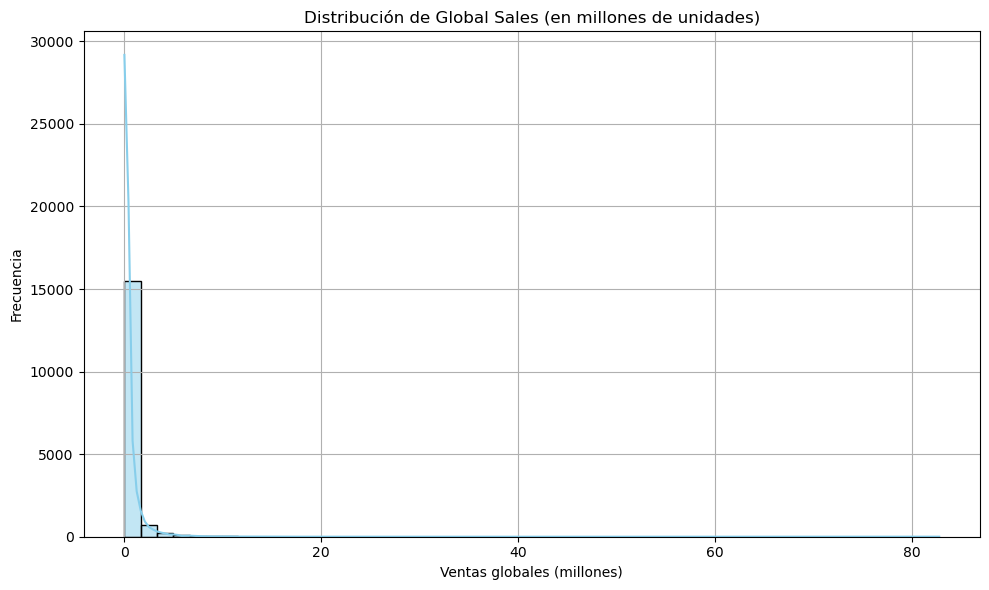

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(#df_video_games['Global_Sales'], bins=50, kde=True, color='skyblue')
plt.title('Distribución de Global Sales (en millones de unidades)')
plt.xlabel('Ventas globales (millones)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.tight_layout()
plt.show()